Dylan Hastings

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

In [156]:
%matplotlib inline

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [157]:
br = pd.read_csv('data/births.csv')

Text(0, 0.5, 'total births per year')

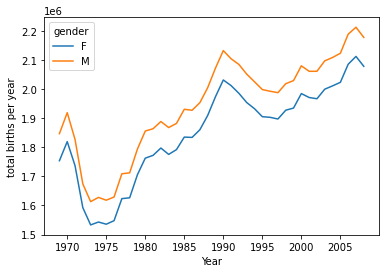

In [158]:
fig, ax = plt.subplots(figsize = (6,4))
brf = br.loc[br.gender == 'F']
female_births = brf.groupby('year')['births'].sum()
ax.plot(female_births.index, female_births.values)
brm = br.loc[br.gender == 'M']
male_births = brm.groupby('year')['births'].sum()
ax.plot(male_births.index, male_births.values)
ax.legend(('F', 'M'), loc=2, title='gender')
ax.set_xlabel("Year")
ax.set_ylabel("total births per year")

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

Andrew Gelman used a Gaussian process to decompose the plot of births by day of year into a periodic component and a residual.  The first plot shows the number of births relative to an average value of 100 as a function of day of the year.  The plot also includes a smoothed line that is filtered to remove noise.  He highlightes holidays that mainly have dips in number of births because births are less likely to be induced, and c-sections less likely to be performed.  The second plot shows the periodic component of the number of births.  These consist of repetitive and generally regular and predictable patters in the time series.  As Gelman indicates, the periodic component due to week is still in effect becuase the data is only taken over the course of 20 years.  By removing the seasonlity from the first births plot, you are left with the residual component in the third plot.  This makes the circled outliers previously discussed much more apparent.

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

In [159]:
quartiles = np.percentile(br['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
br = br.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
br['day'] = br['day'].astype(int)
display(br.head(3))

,year,month,day,gender,births
0,1969,1,1,F,4046
1,1969,1,1,M,4440
2,1969,1,2,F,4454


In [160]:
br = br.dropna()

In [161]:
br = br.loc[br.day <= 31]

In [162]:
br.day=br.day.astype(int)

In [163]:
br.loc[:,'year'] = '2008'
br

,year,month,day,gender,births
0,2008,1,1,F,4046
1,2008,1,1,M,4440
2,2008,1,2,F,4454
3,2008,1,2,M,4548
4,2008,1,3,F,4548
...,...,...,...,...,...
15062,2008,12,29,M,5944
15063,2008,12,30,F,5742
15064,2008,12,30,M,6095
15065,2008,12,31,F,4435


In [164]:
br['month'] = br['month'].astype(str)
br['day'] = br['day'].astype(str)

In [165]:
br.index = pd.to_datetime(br.year+br.month+br.day,format="%Y%m%d", errors='coerce')

In [166]:
br = br.pivot_table('births', [br.index.month, br.index.day])
br

births
1  1   4009.225
   2   4247.400
   3   4500.900
   4   4571.350
   5   4603.625
...         ...
12 27  4850.150
   28  5044.200
   29  5120.150
   30  5172.350
   31  4859.200

[348 rows x 1 columns]

In [167]:
br.index = [pd.datetime(2008, month, day) for month,day in br.index]

<ipython-input-167-493c8db27b48>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  br.index = [pd.datetime(2008, month, day) for month,day in br.index]


In [168]:
display(br.head)

<bound method NDFrame.head of               births
2008-01-01  4009.225
2008-01-02  4247.400
2008-01-03  4500.900
2008-01-04  4571.350
2008-01-05  4603.625
...              ...
2008-12-27  4850.150
2008-12-28  5044.200
2008-12-29  5120.150
2008-12-30  5172.350
2008-12-31  4859.200

[348 rows x 1 columns]>

Text(0, 0.5, 'total births per year')

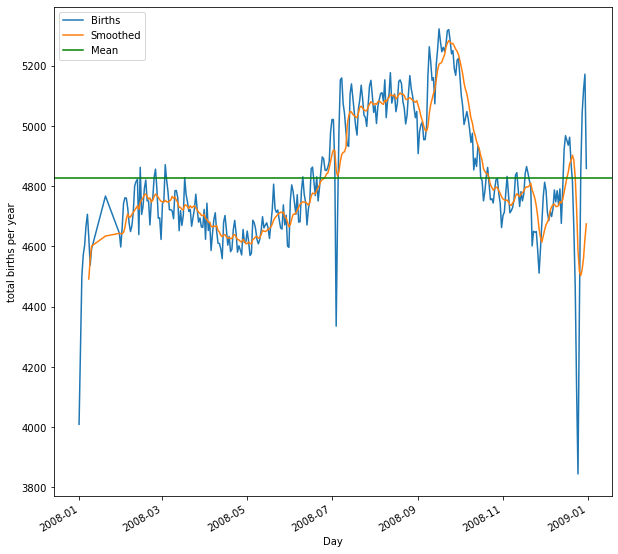

In [169]:
fig, ax = plt.subplots(figsize = (10,10))
br.plot(ax = ax)
br.rolling(window = 8).mean().plot(ax = ax)
plt.axhline(y=br.births.mean(), color = 'g')
ax.legend(('Births', 'Smoothed', 'Mean'), loc=2)
ax.set_xlabel("Day")
ax.set_ylabel("total births per year")

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [170]:
import gzip

In [173]:
with gzip.open("Data/recipe.json.gz", 'r') as f:
    data = (line.strip().decode() for line in f)
    data_json = f"[ {','.join(data)} ]"
    df = pd.read_json(data_json)

In [174]:
breakfast = df['description'].str.contains("breakfast")
breakfast.sum()

3442

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [175]:
def recommend_ingredients(ingredients_list, dataframe):
    '''
    Given a list of basic ingredients, find a recipe
    that uses all those ingredients.
    '''
    
    for ingredient in ingredients_list:
        df[ingredient] = df['ingredients'].str.contains(ingredient)
        
    rp=df.iloc[:, -len(ingredients_list):]
    
    recipes = rp.index[(rp.all(axis=1))].tolist()
    
    print(f"# The rows where these {len(ingredients_list)} ingredients are in the recipe")
    
    return recipes

In [176]:
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

# The rows where these 3 ingredients are in the recipe


[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [177]:
import json

In [179]:
movies_url = {
"movies_metadata": "1RLvh6rhzYiDDjPaudDgyS9LmqjbKH-wh",
"keywords": "1YLOIxb-EPC_7QpkmRqkq9E6j7iqmoEh3",
"ratings": "1_5HNurSOMnU0JIcXBJ5mv1NaXCx9oCVG",
"credits": "1bX9othXfLu5NZbVZtIPGV5Hbn8b5URPf",
"ratings_small": "1fCWT69efrj4Oxdm8ZNoTeSahCOy6_u6w",
"links_small": "1fh6pS7XuNgnZk2J3EmYk_9jO_Au_6C15",
"links": "1hWUSMo_GwkfmhehKqs8Rs6mWIauklkbP",
}

def read_gdrive(url):
    """
    Reads file from Google Drive sharing link
    """
    path = 'https://drive.google.com/uc?export=download&id='+url
    return pd.read_csv(path)

rs = read_gdrive(movies_url["ratings_small"])

In [180]:
#The credits file wasn't working for me from Google Drive, so I downloaded them to the data folder
credits = pd.read_csv('data/credits.csv')

In [181]:
import re

In [182]:
def find_director(json_str):
    object_re = r'{.*?}'
    director_re = r"'job': 'Director'"
    names_re = r"'name': '(.*?)',"
    director = 'Anonymous'
    for match in re.findall(object_re, json_str):
        director_match = re.search(director_re, str(match))
        if director_match:
            name_match = re.search(names_re, str(match))
            if name_match:
                director = name_match.group(1)
                break
    return director

In [183]:
res = [{"movieId": y, "director": find_director(x)} for x,y in zip(credits['crew'], credits['id'])]

directors = pd.DataFrame(res)

In [140]:
df = pd.merge(rs, directors, on='movieId')
df

,userId,movieId,rating,timestamp,director
0,1,1371,2.5,1260759135,Sylvester Stallone
1,4,1371,4.0,949810302,Sylvester Stallone
2,7,1371,3.0,851869160,Sylvester Stallone
3,19,1371,4.0,855193404,Sylvester Stallone
4,21,1371,3.0,853852263,Sylvester Stallone
...,...,...,...,...,...
44991,652,129009,4.0,1442690827,David Swift
44992,653,2103,3.0,948161066,Steven Soderbergh
44993,659,167,4.0,836137550,Iain Softley
44994,659,563,3.0,834694187,Paul Verhoeven


In [154]:
average_rating = df.groupby('director')['rating'].mean()
average_rating = average_rating.sort_values(ascending=False)
average_rating[:47]

director
Paul Breuls            5.0
Karsten Kjær           5.0
Herman Yau             5.0
Stanley Donen          5.0
Aziz Mirza             5.0
Anthony Russo          5.0
Charles Laughton       5.0
Ken Annakin            5.0
Wolfgang Murnberger    5.0
Carlos Diegues         5.0
Carl Schenkel          5.0
Sven Taddicken         5.0
K Raghavendra Rao      5.0
Harry O. Hoyt          5.0
Thomas Vinterberg      5.0
Bret Wood              5.0
Todd Holland           5.0
Tony Gatlif            5.0
Vincent Sherman        5.0
Adam McKay             5.0
John Hough             5.0
W.D. Hogan             5.0
John Harrison          5.0
Wellson Chin           5.0
Xue Xiaolu             5.0
Alfredo De Villa       5.0
Lucy Walker            5.0
Mikhail Kamenetskiy    5.0
Jennifer Azano         5.0
Andrés Wood            5.0
Fernando Fragata       5.0
Nicolás Alcalá         5.0
Frank Borzage          5.0
Phillip J. Roth        5.0
Nathan Hynes           5.0
Zeki Demirkubuz        5.0
Jeff Nichols       

The above directors all have "perfect" ratings in this dataset.